# Project 2 report

*You can delete this cell, and add new cells to put your code and write your report.*

*To add a new code or Markdown cell, click the <kbd>+</kbd> button in the toolbar. By default, this will be a code cell; to change it to Markdown, click the drop-down menu in the toolbar which says <kbd>Code</kbd>, and select <kbd>Markdown</kbd> in the list.*

*To format the text in a Markdown cell, just run the cell. To edit it again, double-click on it. For examples of Markdown formatting, you can double-click on any Markdown cell in any of the course notebooks. For instance, there are lots of examples at the top of the Week 1 tutorial notebook.*

# Air Pollution
Pollution can be gas or liquid or solid. It can also be classified chemically, such as:- oxide, hydrocarbon, acid or other kinds. Pollution can also be classified by what makes it.

Many pollutants go into the air from natural sources. These pollutants include dust, sea salt, volcanic ashes and gases, smoke from forest fires, pollen, and many other materials.[1] In fact, there are many more natural pollutants than pollutants that humans make.[1] However, humans and other living things have adapted to most of these natural pollutants.[1]source https://simple.wikipedia.org/wiki/Air_pollution


# About the notebook


In this notebook data is extracted from BigQuery Public Dataacessible in Kaggle. The BigQurey Helper Object will convert data in cloud storage into Pandas DataFrame object. The query syntax is same as SQL and it will also help to visualize the data easily.

> **BigQuery** is a RESTful web service that enables interactive analysis of massively large datasets working in conjunction with Google Storage. It is an Infrastructure as a Service that may be used complementarily with MapReduce.

Here, I will be analyzing OpenAQ dataset, which has some information about the air pollutants. 

**Measurement units**
       a.  ug/m3 : micro gram/cubic meter
       b.  ppm : Parts Per Million

**Pollutants**
    a. O3 : Ozone gas
    b. SO2 : Sulphur Dioxed
    c. NO2 : Nitrogen Dioxed
    d. PM2.5 : Particles with an aerodynamic diameter less than  2.5μm 
    e. PM10 : Particles with an aerodynamic diameter less than  10μm 
    f. CO : Carbon monoxide

So, let's dive in immediately and find out the results!

In [19]:
# https://github.com/SohierDane/BigQuery_Helper/blob/master/bq_helper.py

"""
Helper class to simplify common read-only BigQuery tasks.
"""


import pandas as pd
import time

from google.cloud import bigquery


class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.
    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1
        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.
        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))

# Importing the liabraries

In [24]:
# uploading the basic datascience and big query liabraries 
import os
import time
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows =10

In [25]:
# !pip install google-cloud-bigquery
# # https://cloud.google.com/bigquery/docs/introduction
# from google.cloud import bigquery

# EDA

**I will do exploratory data analysis and data visualizatiion **

In [26]:
# matplotlib for plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# import plotly
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as fig_fact
# from bq_helper import BigQueryHelper
import folium
import folium.plugins as plugins

%matplotlib inline

In [27]:
import getpass

from sys import platform
if platform == "linux" or platform == "linux2":
    os.environ["PROJ_LIB"] = f"~/anaconda3/Library/share"
elif platform == "darwin":
    os.environ["PROJ_LIB"] = f"/Users/{getpass.getuser()}/anaconda3/Library/share"
elif platform == "win32":
    os.environ["PROJ_LIB"] = f"C:/Users/{getpass.getuser()}/anaconda3/Library/share"
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

In [28]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./.keys/openaq-333400-68a91c31502c.json"

# exploring the dataset

Now, I will be creating a dataset and list down all the tables for this particular dataset.

In [29]:
# create a helper object for this dataset
open_aq = BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="openaq")


# print all the tables in this dataset (there's only one!)
open_aq.list_tables()

['global_air_quality']

In [30]:
#Schema 
open_aq.table_schema('global_air_quality')

,name,type,mode,description
0,location,STRING,NULLABLE,Location where data was measured
1,city,STRING,NULLABLE,City containing location
2,country,STRING,NULLABLE,Country containing measurement in 2 letter ISO...
3,pollutant,STRING,NULLABLE,Name of the Pollutant being measured. Allowed ...
4,value,FLOAT,NULLABLE,Latest measured value for the pollutant
...,...,...,...,...
6,unit,STRING,NULLABLE,The unit the value was measured in coded by UC...
7,source_name,STRING,NULLABLE,Name of the source of the data
8,latitude,FLOAT,NULLABLE,Latitude in decimal degrees. Precision >3 deci...
9,longitude,FLOAT,NULLABLE,Longitude in decimal degrees. Precision >3 dec...


There is only one table (**global_air_quality**) in the dataset **openaq**.

Next I will look into columns and the datatype of this table

### Display Table *global_air_quality*

In [31]:
# print the first couple rows of the "global_air_quality" dataset
open_aq.head("global_air_quality")

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


# Air Quality Index(AQI) : Over the Years
An air quality index (AQI) is used by government agencies to communicate to the public how polluted the air currently is or how polluted it is forecast to become.Public health risks increase as the AQI rises. Different countries have their own air quality indices, corresponding to different national air quality standards.  source https://en.wikipedia.org/wiki/Air_quality_index

In [32]:
# import pyarrow
query_aqi = """
            SELECT EXTRACT(YEAR FROM timestamp) as `Year`,
                   AVG(value) as `Average`,
                   latitude,
                   longitude
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE unit = 'µg/m³'
        GROUP BY Year, 
                 latitude,
                 longitude
        """
aqi = open_aq.query_to_pandas_safe(query_aqi)
aqi.head()

,Year,Average,latitude,longitude
0,2018,221.510,12.912811,77.609220
1,2018,263.530,12.938906,77.697270
2,2017,17.110,12.938906,77.697270
3,2018,445.295,12.977347,77.570694
4,2018,105.575,12.991670,77.545830


From the map it is visilbe the no of countries will be effected due to air pollution are increasing.
Now,I will look into the countries listed in the AQI.

# Listed Countries in Air Quality Index (AQI)

In [33]:
query = """SELECT country,COUNT(country) as `count`
    FROM `bigquery-public-data.openaq.global_air_quality`
    GROUP BY country
    HAVING COUNT(country) >10
    ORDER BY `count` DESC
    """
cnt = open_aq.query_to_pandas_safe(query)

cnt.head(20)

,country,count
0,US,3723
1,ES,2123
2,FR,1608
3,IN,1531
4,DE,1455
...,...,...
15,CA,367
16,CZ,328
17,NL,279
18,PT,252


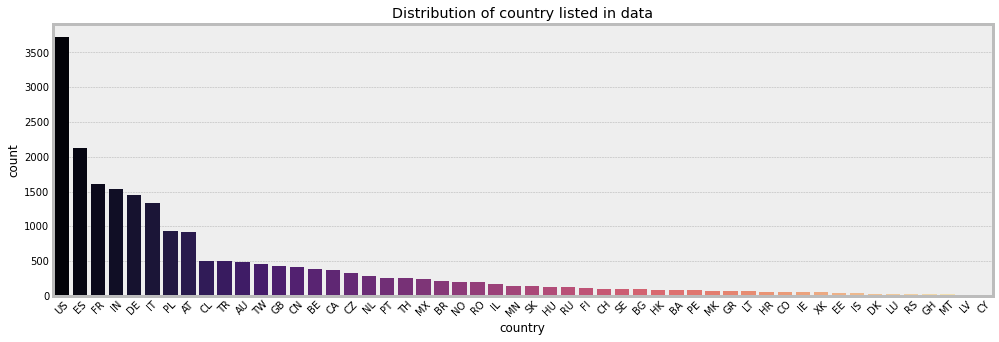

In [34]:
plt.style.use('bmh')
plt.figure(figsize=(15,5))
sns.barplot(cnt['country'], cnt['count'], palette='magma')
plt.xticks(rotation=45)
plt.title('Distribution of country listed in data');

# Locations

Shown below are some locations where average AQI reports to be the maximum.

Other locations in World Map are also shown below.

In [35]:
query = """SELECT city,latitude,longitude,averaged_over_in_hours,
            AVG(value) as `Average`
            FROM `bigquery-public-data.openaq.global_air_quality`
            WHERE unit = 'µg/m³'
            GROUP BY latitude,city,longitude,averaged_over_in_hours   
            ORDER BY Average DESC
            """
location = open_aq.query_to_pandas_safe(query)
location.dropna(axis=0, inplace=True)
location.head(10)

,city,latitude,longitude,averaged_over_in_hours,Average
1,Satna,24.590826,80.857430,1.00,20070.750000
2,Delhi,28.667086,77.130130,1.00,8417.833333
3,Toledo,39.868060,-4.020830,1.00,8359.000000
4,Granada,37.165680,-3.600100,1.00,7041.156000
5,Delhi,28.652740,77.297790,1.00,3426.666667
6,Zonguldak,41.276466,31.433418,1.00,3226.400000
8,Brescia,45.504723,10.313056,1.00,2188.626133
9,Muğla,37.311210,27.782932,1.00,1872.200000
10,Nandesari,22.410803,73.097920,0.25,1474.300000
11,Kalyan,19.252920,73.142020,0.25,1321.496667


We can see that Indian cities are holding the topmost places in the leaderboard.
But, there are many other places in the dataset which are also not lagging.
We can see those places in the map below.

# AQI Value Distribution on map

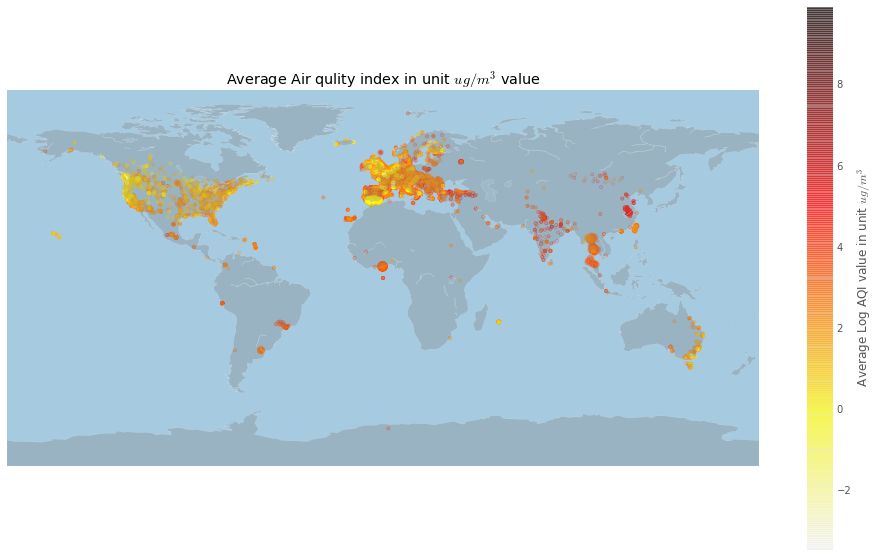

In [36]:
plt.style.use('ggplot')
f,ax = plt.subplots(figsize=(15,10))
m1 = Basemap(projection='cyl', llcrnrlon=-180, urcrnrlon=180, llcrnrlat=-90, urcrnrlat=90,
            resolution='c',lat_ts=True)

m1.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m1.fillcontinents(color='grey', alpha=0.3)
m1.drawcoastlines(linewidth=0.1, color="white")
m1.shadedrelief()

hour = location['averaged_over_in_hours']
avg = np.log(location['Average'])
m1loc = m1(location['latitude'].tolist(),location['longitude'])
m1.scatter(m1loc[1],m1loc[0],lw=3,alpha=0.5,cmap='hot_r',\
          c=avg,s=hour)
plt.title('Average Air qulity index in unit $ug/m^3$ value')
plt.colorbar(label=' Average Log AQI value in unit $ug/m^3$');

So, we can see that the pollution level in different places are at an alarming condition. The European countries(topping the list, USA,South and South-East Asian conutries are making more pollution, where as Australia, Africa and South Africa do not make up to the topper's list.

# AQI distribuation in Netherlands
## since I am interested in exploring the AQI distribution of various cities in Netherlands.
I will filter the data on NL

In [37]:
#NL location
query = """SELECT 
            MAX(latitude) as `max_lat`,
            MIN(latitude) as `min_lat`,
            MAX(longitude) as `max_lon`,
            MIN(longitude) as `min_lon`
            FROM `bigquery-public-data.openaq.global_air_quality`
            WHERE country = 'NL' 
        """
nl_loc = open_aq.query_to_pandas_safe(query)
nl_loc

,max_lat,min_lat,max_lon,min_lon
0,53.3304,50.8459,6.93243,3.74948


In [38]:
query = """ SELECT city,latitude,longitude,averaged_over_in_hours,
            AVG(value) as `Average`
            FROM `bigquery-public-data.openaq.global_air_quality`
            WHERE country = 'NL' AND unit = 'µg/m³'
            GROUP BY latitude,city,longitude,averaged_over_in_hours,country
            ORDER BY Average DESC
        """

nl_aqi = open_aq.query_to_pandas_safe(query)
nl_aqi.head()

,city,latitude,longitude,averaged_over_in_hours,Average
0,Biest Houtakker,51.5184,5.14845,1.0,46.400
1,Westmaas,51.7866,4.45053,24.0,35.150
2,Wieringerwerf,52.8037,5.05051,1.0,35.145
3,Philippine,51.2945,3.74948,24.0,33.870
4,Eindhoven,51.4687,5.47235,24.0,33.870


Text(0.5, 1.0, 'Average Air qulity index in unit $ug/m^3$ of NL')

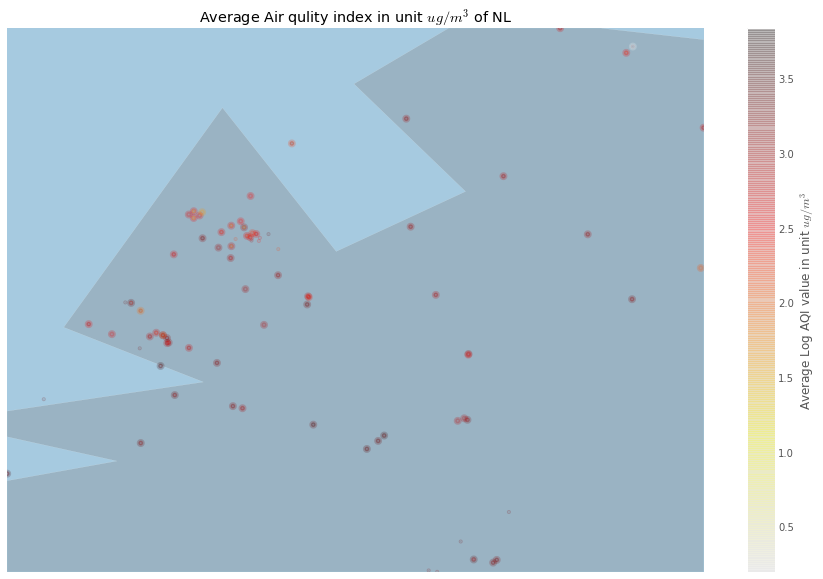

In [39]:
# NL
min_lat = nl_loc['min_lat']
max_lat = nl_loc['max_lat']
min_lon = nl_loc['min_lon']
max_lon = nl_loc['max_lon']

plt.figure(figsize=(14,10))
m2 = Basemap(projection='cyl', llcrnrlon=min_lon, urcrnrlon=max_lon, llcrnrlat=min_lat, urcrnrlat=max_lat,
            resolution='c',lat_ts=True)
m2.drawcounties()
m2.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m2.fillcontinents(color='grey', alpha=0.3)
m2.drawcoastlines(linewidth=0.1, color="white")
m2.drawstates()
avg = np.log((nl_aqi['Average']))
h = nl_aqi['averaged_over_in_hours']
m2loc = m2(nl_aqi['latitude'].tolist(),nl_aqi['longitude'])
m2.scatter(m2loc[1],m2loc[0],s = h,c = avg,lw=3,alpha=0.2,zorder=3,cmap='hot_r')
plt.colorbar(label = 'Average Log AQI value in unit $ug/m^3$')
plt.title('Average Air qulity index in unit $ug/m^3$ of NL')

In [40]:
#INDIA location
query = """SELECT 
            MAX(latitude) as `max_lat`,
            MIN(latitude) as `min_lat`,
            MAX(longitude) as `max_lon`,
            MIN(longitude) as `min_lon`
            FROM `bigquery-public-data.openaq.global_air_quality`
            WHERE country = 'IN' """
in_loc = open_aq.query_to_pandas_safe(query)
in_loc

,max_lat,min_lat,max_lon,min_lon
0,31.62,8.51491,92.719284,72.59191


In [41]:
query = """ SELECT city,latitude,longitude,averaged_over_in_hours,
            AVG(value) as `Average`
            FROM `bigquery-public-data.openaq.global_air_quality`
            WHERE country = 'IN' AND unit = 'µg/m³'
            GROUP BY latitude,city,longitude,averaged_over_in_hours,country """
in_aqi = open_aq.query_to_pandas_safe(query)
in_aqi

,city,latitude,longitude,averaged_over_in_hours,Average
0,Bengaluru,12.912811,77.609220,0.25,221.510000
1,Bengaluru,12.938906,77.697270,0.25,214.246000
2,Bengaluru,12.977347,77.570694,0.25,445.295000
3,Bengaluru,12.991670,77.545830,0.25,105.575000
4,Chennai,12.992514,80.237450,0.25,190.764000
...,...,...,...,...,...
274,Delhi,28.776200,77.051070,0.25,100.240000
275,Delhi,28.822836,77.101980,0.25,284.616667
276,Delhi,28.650800,77.315200,NaN,1300.000000
277,Delhi,28.652740,77.297790,1.00,3426.666667


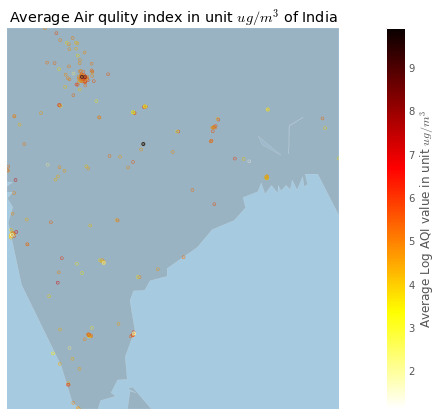

In [42]:
# INDIA
min_lat = in_loc['min_lat']
max_lat = in_loc['max_lat']
min_lon = in_loc['min_lon']
max_lon = in_loc['max_lon']

plt.figure(figsize=(15,7))
m3 = Basemap(projection='cyl', llcrnrlon=min_lon, urcrnrlon=max_lon, llcrnrlat=min_lat, urcrnrlat=max_lat,
            resolution='c',lat_ts=True)
m3.drawcounties()
m3.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m3.fillcontinents(color='grey', alpha=0.3)
m3.drawcoastlines(linewidth=0.1, color="white")
m3.drawstates()
avg = np.log((in_aqi['Average']))
h = in_aqi['averaged_over_in_hours']
m3loc = m3(in_aqi['latitude'].tolist(),in_aqi['longitude'])
m3.scatter(m3loc[1],m3loc[0],s = h,c = avg,lw=3,alpha=1,cmap='hot_r')
plt.colorbar(label = 'Average Log AQI value in unit $ug/m^3$')
plt.title('Average Air qulity index in unit $ug/m^3$ of India');

# Source_name to the corresponding country

In the dataset,that there is an attribute called 'source_name'. This attribute points to the source which provides the pollution data for a particular country.
So, let's find out the different source names and their corresponding reporting countries. 

In [43]:
query_source = """
                    SELECT 
                    DISTINCT source_name, 
                             country
                    FROM `bigquery-public-data.openaq.global_air_quality`
                    ORDER BY source_name
                    """

source = open_aq.query_to_pandas_safe(query_source)

source.head(10)

,source_name,country
0,ARPALAZIO,IT
1,Agaar.mn,MN
2,AirNow,CL
3,AirNow,AU
4,AirNow,ID
5,AirNow,UG
6,AirNow,VM
7,AirNow,IN
8,AirNow,GT
9,AirNow,SU


So, listed above are some of the countries along with their source providers. 
For example, AirNow provides **Air Quality Reports **for countries like Australia (AU), United States (US), Chile (CL), Mexico (MX) and Canada (CA), to be named a few. 

Now, we will be checking country count per source in the below query.

In [44]:
query_country_count_per_source = """
                    SELECT 
                    DISTINCT source_name,
                    COUNT(country) AS Country_Count
                    FROM `bigquery-public-data.openaq.global_air_quality`
                    GROUP BY source_name
                    HAVING Country_Count > 50
                    ORDER BY Country_Count DESC
                    """
# Country_Count > 50 (Ignoring the negligible values)
country_count_per_source = open_aq.query_to_pandas_safe(query_country_count_per_source)

country_count_per_source.head(10)

,source_name,Country_Count
0,AirNow,4295
1,EEA Spain,1971
2,EEA France,1608
3,EEA Germany,1455
4,caaqm,1325
5,EEA Italy,982
6,EEA Austria,917
7,GIOS,865
8,Chile - SINCA,498
9,Turkey,497


According to the data produced above, we will now plot a graph to find out the leading sources(in terms of number of countries) to provide the **Air Quality Data/Pollution Report**.

# Graph Plot

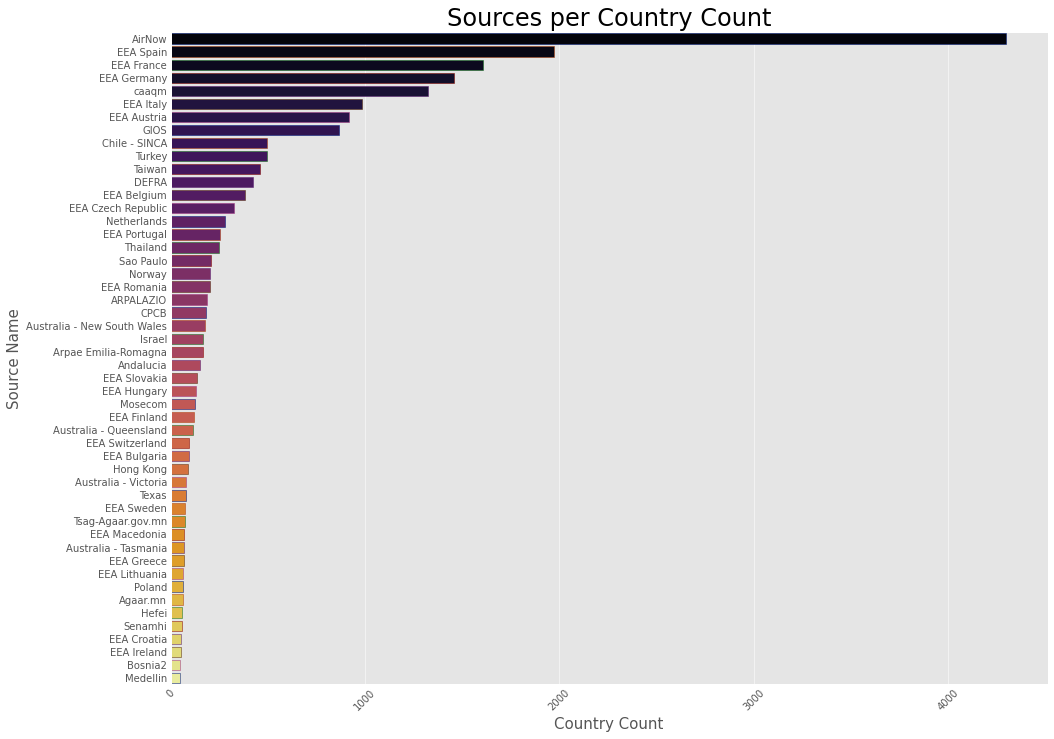

In [45]:
plt.subplots(figsize=(14,12))
sns.barplot(x='Country_Count',y='source_name',data=country_count_per_source,palette='inferno',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Source Name', fontsize=15)
plt.xticks(rotation=45,fontsize=10)
plt.xlabel('Country Count', fontsize=15)
plt.title('Sources per Country Count', fontsize=24)
plt.savefig('sources_per_country_count.png')
plt.show()

Here, we can see that sources like **AirNow**, **EEA France**, **EEA Spain**, **EEA Germany**, **EEA Austria**, **EEA Czech Republic** tops the leaderboard.

So, for our further analysis, we will consider the pollutant data from the above stated sources.

Hence, the next step will be to identify the different pollutants.

# Exploring different pollutants

In [46]:
query_pollutants = """
                    SELECT 
                    DISTINCT pollutant, unit
                    FROM `bigquery-public-data.openaq.global_air_quality`
                    WHERE source_name IN ('AirNow', 'EEA France', 'EEA Spain', 'EEA Germany', 'EEA Austria', 'EEA Czech Republic','Netherlands')
                    ORDER BY pollutant
                    """

pollutants = open_aq.query_to_pandas_safe(query_pollutants)

pollutants.head(15)

,pollutant,unit
0,bc,µg/m³
1,co,ppm
2,co,µg/m³
3,no2,ppm
4,no2,µg/m³
...,...,...
6,o3,µg/m³
7,pm10,µg/m³
8,pm25,µg/m³
9,so2,ppm


So, the noted pollutants are:

*  Black Carbon
*  Carbon Monoxide
*  Nitrogen Dioxide
*  Ozone
*  Sulphur Dioxide
*  pm10
*  pm25

Hence, we will be focusing more on these pollutants now.

# Black Carbon 

**Black carbon** is the **sooty black material **emitted from gas and diesel engines, coal-fired power plants, and other sources that burn fossil fuel. It comprises a significant portion of particulate matter or PM, which is an air pollutant.

**Black Carbon (BC) **has recently emerged as a major contributor to global climate change, possibly second only to CO2 as the main driver of change. BC particles strongly absorb sunlight and give soot its black color. BC is produced both naturally and by human activities as a result of the incomplete combustion of fossil fuels, biofuels, and biomass. Primary sources include emissions from diesel engines, cook stoves, wood burning and forest fires. Reducing CO2 emissions is essential to avert the worst impacts of future climate change, but CO2 has such a long atmospheric lifetime that it will take several decades for CO2 concentrations to begin to stabilize after emissions reductions begin. In contrast, BC remains in the atmosphere for only a few weeks, so cutting its emissions would immediately reduce the rate of warming, particularly in the rapidly changing Arctic. Moreover, reduced exposure to BC provides public health co-benefits, especially in developing countries. Technologies that can reduce global BC emissions are available today.

# Analysis
## (µg/m³)

In [47]:
query_bc = """
    SELECT country, 
           source_name,
           avg(value) as Avg_Value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'bc'
      AND unit = 'µg/m³'
      GROUP BY country, source_name
      ORDER BY Avg_Value ASC
        """

bc = open_aq.query_to_pandas_safe(query_bc)

bc.head(10)

,country,source_name,Avg_Value
0,PL,GIOS,0.453266
1,US,AirNow,15.470741


As per **AirNow**(as mentioned in the dataset), **US**  and **PL** are the only country which produces **Black Carbon**
Hence, no graph plot could be produced.

# Carbon Monoxide 

**Carbon monoxide**, also known as CO, is called the "**Invisible Killer**" because it's a colorless, odorless, poisonous gas. More than 150 people in the Unites States die every year(not only in US, but also in other countries) from accidental non-fire related CO poisoning associated with consumer products, including generators. Other products include faulty, improperly-used or incorrectly-vented fuel-burning appliances such as furnaces, stoves, water heaters and fireplaces.

# Analysis - I
## (µg/m³)

In [48]:
query_co = """
    SELECT country, 
           avg(value) as Avg_Value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'co'
      AND unit = 'µg/m³'
      GROUP BY country, source_name
      ORDER BY Avg_Value ASC
        """

co = open_aq.query_to_pandas_safe(query_co)

co.head(10)

,country,Avg_Value
0,TR,-4042.242615
1,NL,-397.854860
2,LV,0.120000
3,IE,0.164358
4,LT,0.168162
5,BE,2.348400
6,AD,100.000000
7,HR,100.000000
8,DK,107.142857
9,MT,107.494500


The query produced some country names above which has CO gas values (in µg/m³), and the graphical representation is shown below:

# Graph Plot

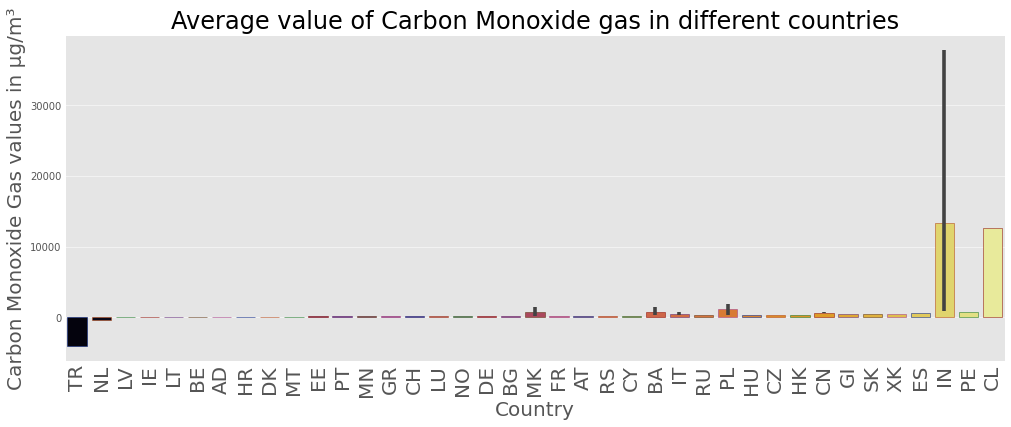

In [49]:
plt.subplots(figsize=(15,6))
sns.barplot(x='country',y='Avg_Value',data=co,palette='inferno',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Carbon Monoxide Gas values in µg/m³', fontsize=20)
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.title('Average value of Carbon Monoxide gas in different countries', fontsize=24)
plt.savefig('avg_co.png')
plt.show()

The above plot shows Turky(TR) and Netherlands(NL) have the most negative gas values in µg/m³ (which indicates less pollution), whereas Maxico (MK) tops the list.

# Carbon Monoxide : Analysis - II
## (ppm)

In [50]:
query_co_ppm = """
    SELECT country, 
           avg(value) as Avg_Value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'co'
      AND unit = 'ppm'
      GROUP BY country, source_name
      ORDER BY Avg_Value ASC
        """

co_ppm = open_aq.query_to_pandas_safe(query_co_ppm)

co_ppm.head(10)

,country,Avg_Value
0,CO,-3331.702853
1,AU,-158.628571
2,AU,0.155000
3,US,0.171429
4,CA,0.194545
5,AU,0.300000
6,AU,0.311111
7,US,0.383846
8,AR,0.390000
9,IL,0.404762


The query produced some country names above which has CO gas values (in ppm), and the graphical representation is shown below:

# Graph Plot

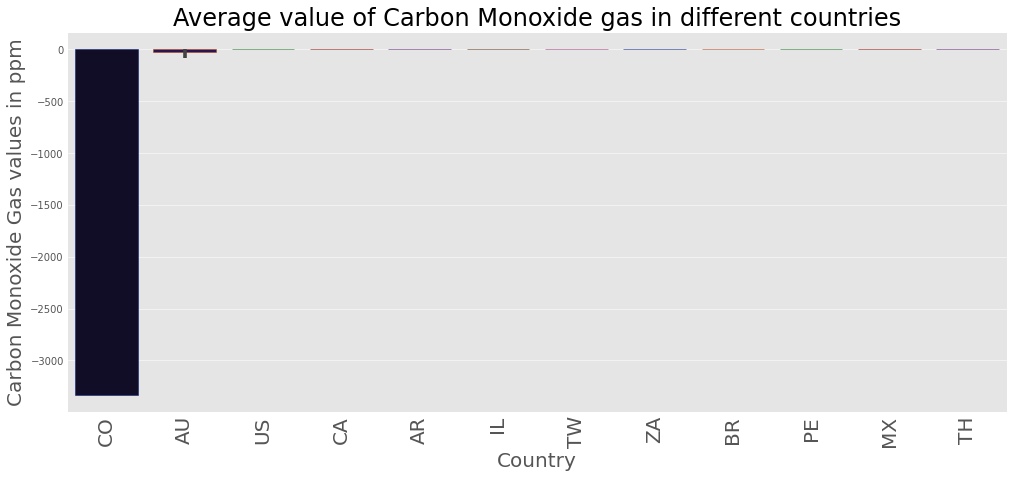

In [51]:
plt.subplots(figsize=(15,7))
sns.barplot(x='country',y='Avg_Value',data=co_ppm,palette='inferno',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Carbon Monoxide Gas values in ppm', fontsize=20)
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.title('Average value of Carbon Monoxide gas in different countries', fontsize=24)
plt.savefig('avg_co_ppm.png')
plt.show()

The above plot shows Columbia(CO) has negative value of carbon monooxide, Australia(AU) is at the verge of 0 and Maxico tops the list. 

# Nitrogen Dioxide : Analysis I
## (µg/m³)

In [52]:
query_no2 = """
    SELECT country, 
           avg(value) as Avg_Value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'no2'
      AND unit = 'µg/m³'
      GROUP BY country, source_name
      ORDER BY Avg_Value ASC
        """

no2 = open_aq.query_to_pandas_safe(query_no2)

no2.head(5)

,country,Avg_Value
0,NL,-87.521392
1,IT,-12.528302
2,AD,3.000000
3,MT,3.395087
4,IS,3.765910


# Graph Plot

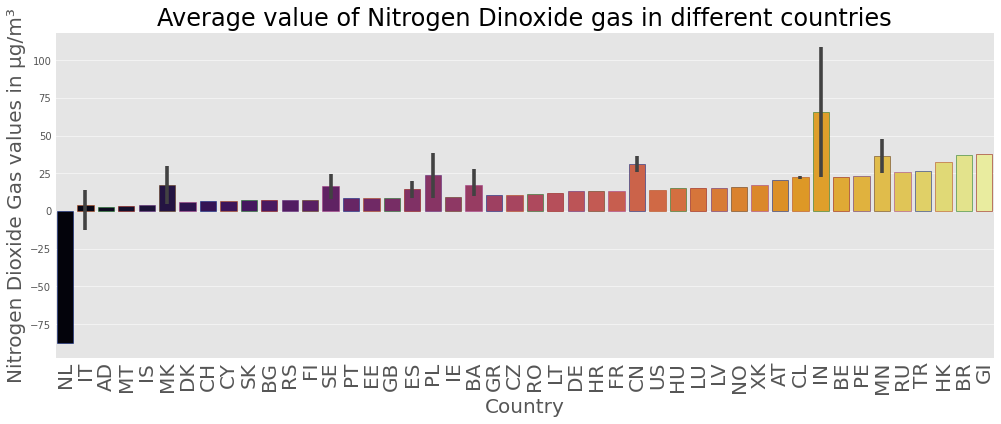

In [53]:
plt.subplots(figsize=(15,6))
sns.barplot(x='country',y='Avg_Value',data=no2,palette='inferno',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Nitrogen Dioxide Gas values in µg/m³', fontsize=20)
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.title('Average value of Nitrogen Dinoxide gas in different countries', fontsize=24)
plt.savefig('avg_no2.png')
plt.show()

# Nitrogen Dioxide : Analysis II
## (ppm)

In [54]:
query_no2_ppm = """
    SELECT country, 
           avg(value) as Avg_Value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'no2'
      AND unit = 'ppm'
      GROUP BY country, source_name
      ORDER BY Avg_Value ASC
        """

no2_ppm = open_aq.query_to_pandas_safe(query_no2_ppm)

no2_ppm.head(5)

,country,Avg_Value
0,CO,-5713.704342
1,AU,-1005.186714
2,CA,0.002083
3,US,0.003009
4,US,0.004539


# Graph Plot

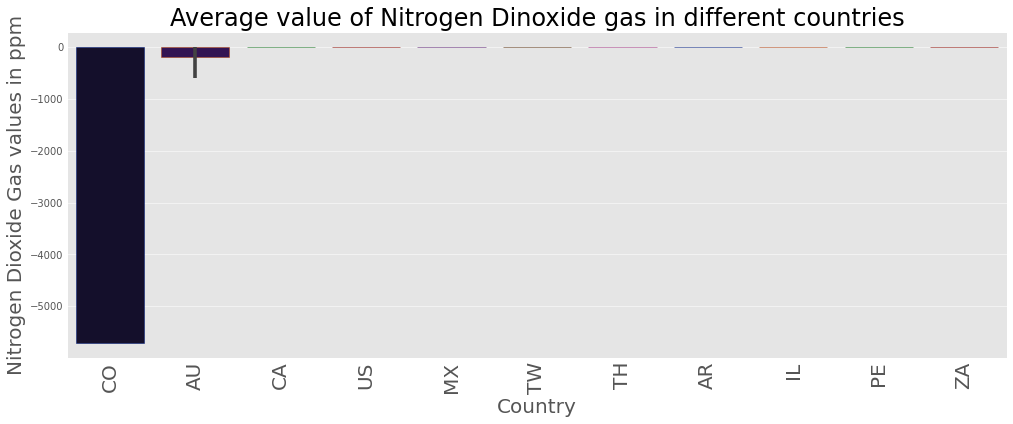

In [55]:
plt.subplots(figsize=(15,6))
sns.barplot(x='country',y='Avg_Value',data=no2_ppm,palette='inferno',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Nitrogen Dioxide Gas values in ppm', fontsize=20)
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.title('Average value of Nitrogen Dinoxide gas in different countries', fontsize=24)
plt.savefig('avg_no2_ppm.png')
plt.show()

# Ozone : Analysis I
## (µg/m³)

In [56]:
query_o3 = """
    SELECT country, 
           avg(value) as Avg_Value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'o3'
      AND unit = 'µg/m³'
      GROUP BY country, source_name
      ORDER BY Avg_Value ASC
        """

o3 = open_aq.query_to_pandas_safe(query_o3)

o3.head(10)

,country,Avg_Value
0,NL,-68.281429
1,BA,10.000000
2,PL,13.583333
3,MK,14.000000
4,PE,14.716000
5,HK,16.306250
6,BA,19.000000
7,HU,19.310595
8,CN,21.666667
9,CN,22.200000


# Graph Plot

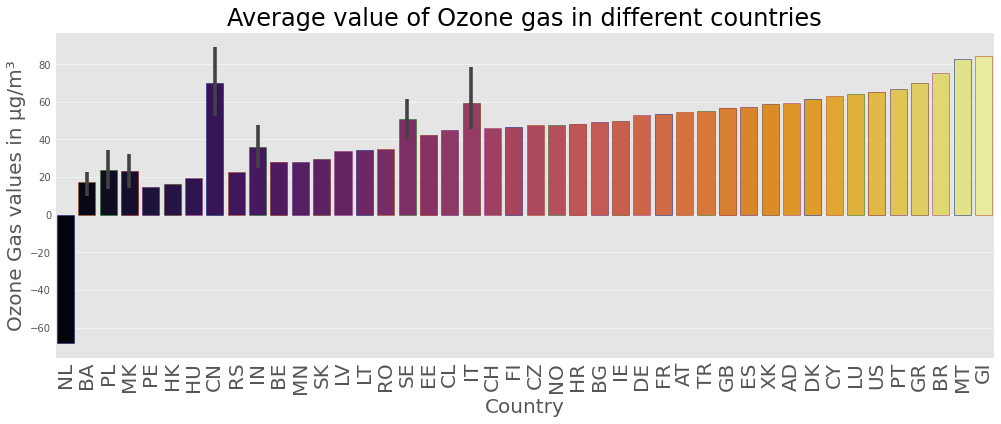

In [57]:
plt.subplots(figsize=(15,6))
sns.barplot(x='country',y='Avg_Value',data=o3,palette='inferno',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Ozone Gas values in µg/m³', fontsize=20)
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.title('Average value of Ozone gas in different countries', fontsize=24)
plt.savefig('avg_o3.png')
plt.show()

# Ozone : Analysis II
## (ppm)

In [58]:
query_o3_ppm = """
    SELECT country, 
           avg(value) as Avg_Value
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    WHERE
      pollutant = 'o3'
      AND unit = 'ppm'
      GROUP BY country, source_name
      ORDER BY Avg_Value ASC
        """

o3_ppm = open_aq.query_to_pandas_safe(query_o3_ppm)

o3_ppm.head(5)

,country,Avg_Value
0,CO,-3332.996756
1,AU,-714.197286
2,BM,0.001000
3,AU,0.004747
4,AE,0.005000


# Graph Plot

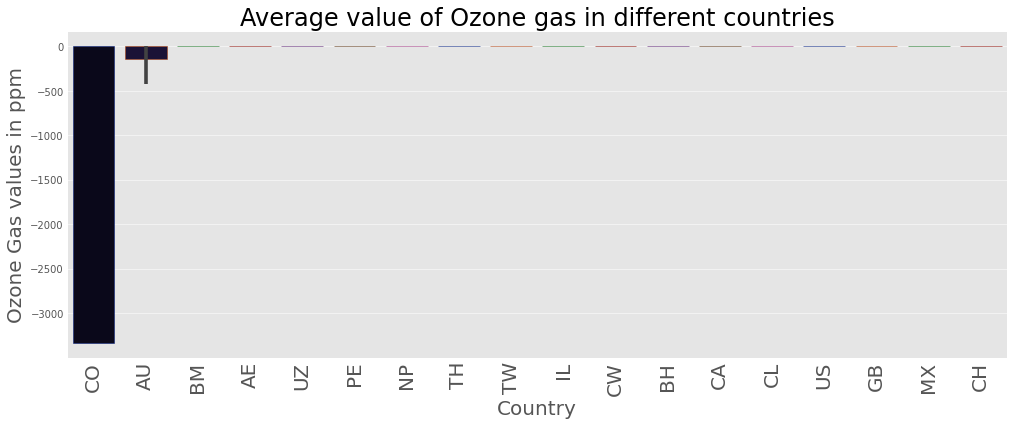

In [59]:
plt.subplots(figsize=(15,6))
sns.barplot(x='country',y='Avg_Value',data=o3_ppm,palette='inferno',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Ozone Gas values in ppm', fontsize=20)
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Country', fontsize=20)
plt.title('Average value of Ozone gas in different countries', fontsize=24)
plt.savefig('avg_o3_ppm.png')
plt.show()

next I will do the analysis of pollutants on country level. The countrywise dataset can be downloaded here(https://openaq.org/#/?_k=i1ibq1) for future analysis.